There are three main parts in the project, each with their corresponding deadline. Part 1, due 11/23, 11:59pm ET. You are given historic data from many customers and their purchasing decisions of the products at various prices. You will train models to estimate personalized demand curves, given the data you have for each user. Among other deliverables, you will submit prices for each item for each user in a test set. This part is a direct extension of the homework assignments, combining recommendations, demand estimation, and optimal one-shot pricing for two products (without capacity constraints).

Part 1 (Due 11/23, 11:59pm ET) This part is all about demand estimation for multiple products; it combines concepts learned in both the recommendations and pricing modules.

The setting is as follows: You have unlimited copies of each of two items. For each of the two items, you have an item vector trained using past interactions on your website. Customers sequentially enter your store. For every customer, you observe three customer covariates. For about half of the customers, you also observe a noisy user vector trained using that user’s past interactions on your website. Assume that, on average, customers with the additional data are no different than customers without the additional data. You set personalized prices for each customer, for each item. The customer buys at most 1 item, based on their valuation of the item and the prices you set. (We use the user model taught in class, where users buy the item that maximizes their value for the item minus the price, if this number is greater than 0; ties are broken randomly). Your goal is to set prices to maximize profit.

The general strategy we recommend is to train a model for the demand for each item, which takes as input the prices, user covariates, and the dot product of each of the item vectors with the user vector. For users without a user vector, you will need to solve the “cold-start” problem and still generate predictions.

Training data -- we provide you the following: The 2 item vectors 14000 past customers. For each customer, we provide user covariates; for half of the training customers, we also provide their user vectors. For each customer, we further provide you the prices they were offered for each of the two items, as well as their purchasing decisions.

This data is available here: https://orie5355.github.io/Fall_2021/static_files/project/Project_part_1_training_data.zip

Test data We will provide you covariate and (for some) user vector data on some new test customers. You will calculate the prices that you would offer to each test customer for each item.

Submission information [Details TBA] You will submit Your code. Your calculated prices for each test customer. We will calculate the overall revenue obtained from the test customers and (partially) base your grade on it.


https://docs.google.com/document/d/1DiCQpuYaxtFTgQrF0vW37GuKf0yIRUd4t0W1IZMeD1o/edit

In [1]:
pip install --upgrade pandas --user

Requirement already up-to-date: pandas in c:\users\quick\anaconda3\lib\site-packages (1.3.4)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import pickle
def openpickle(filename):
    with open(filename, "rb") as readfile:
        loaded = pickle.load(readfile)
    return loaded

C:\Users\quick\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In this document, we help you load the training data that we're initially giving you for Part 1 of the project. We will give you test data for Part 1 soon as well, well before the Part 1 deadline.

The training data is composed of 14000 customers.

For every customer, you have:
1. `train_pricing_decisions`: a user index, a price they were offered for each item, and their decision for what item they purchased. `-1` means they purchased neither item, `0` means they purchased item 0, `1` means they purchased item 1. 

2. `train_covariate`: three covariates for each user. Think of these as demographic covariates. 

Furthermore, for half of the customers, you have additional data on them: `train_noisy_embedding`. These are 10 additional dimensions of covariates; think of these as a (noisy) embedding/vector that you might learn about the users, from past interactions on your website (as we did in the recommendations section). Note that the _index_ of the dataframe corresponds to the user index. So, to get the user with user_index=2, use `train_noisy_embedding.loc[2]`. 

Finally, for each of two items, you have an embedding/item vector, also trained using past interactions. For users for whom you have vectors, the item and user vectors should substantially help in learning the demand function for that user. (hint: as we did in the recommendations section, start by taking a dot product between the user and item vectors).

In [3]:
train_pricing_decisions = pd.read_csv('train_prices_decisions.csv')
train_covariate = openpickle('train_covariate')
train_noisy_embedding = openpickle('train_noisy_embedding')
item0_embedding = openpickle('item0embedding')
item1_embedding = openpickle('item1embedding')
test_covariate = openpickle('test_covariate')
test_noisy_embedding = openpickle('test_noisy_embedding')

In [4]:
train_noisy_embedding.shape, train_covariate.shape, train_pricing_decisions.shape

((7000, 10), (14000, 3), (14000, 4))

In [5]:
train_noisy_embedding.head()

,0,1,2,3,4,5,6,7,8,9
2,-0.104811,-0.221653,0.100601,-0.098699,-1.332734,0.127682,-0.027440,-0.186758,0.846753,0.117480
3,-0.968859,-0.063834,0.060057,0.152638,-1.598490,-0.086009,0.071892,0.446409,-0.266268,0.081822
10,-0.278691,-0.019750,-0.163263,-0.119105,-2.169863,0.114326,-0.262751,-0.071262,-0.554428,-0.119456
11,-0.063279,-0.012065,-0.096779,0.056117,-1.607019,0.173906,0.081938,-0.310020,-0.342731,-0.000527
12,-0.449792,0.211078,-0.033153,0.051038,-1.672873,-0.019274,0.257633,0.069289,-0.016032,0.102461


In [6]:
train_noisy_embedding.loc[10]

0   -0.278691
1   -0.019750
2   -0.163263
3   -0.119105
4   -2.169863
5    0.114326
6   -0.262751
7   -0.071262
8   -0.554428
9   -0.119456
Name: 10, dtype: float64

In [7]:
train_covariate.head()

,Covariate 1,Covariate 2,Covariate 3
1,0.729640,1.095115,1.188253
2,0.863392,0.281688,0.224007
3,-1.015676,-0.952738,-1.094953
4,-0.956540,-0.564787,-0.814503
5,0.159077,-0.172509,-0.028074


In [8]:
train_pricing_decisions.head()

,user_index,item_bought,price_item_0,price_item_1
0,1,0,0.719986,2.356496
1,2,1,0.296607,1.443239
2,3,0,1.652173,3.554441
3,4,1,1.358742,0.326100
4,5,0,1.082251,3.010197


In [9]:
train_pricing_decisions.price_item_0.hist()

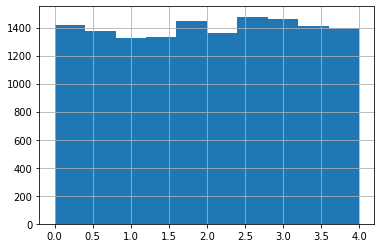

In [10]:
train_pricing_decisions.price_item_1.hist()

The following plot shows the "1-dimensional" choice for item 0: how the percentage of people who bought item 0 changes with the item 0 price.

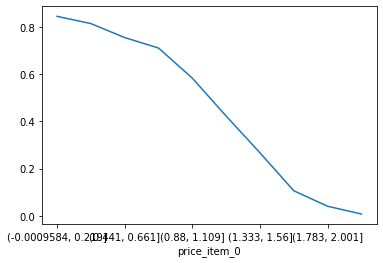

In [11]:
train_pricing_decisions.groupby(pd.qcut(train_pricing_decisions.price_item_0, 10))['item_bought'].agg(lambda x: np.mean([y==0 for y in x])).plot(kind='line')

Of course, the price for item 0 also affects the percentage of people who bought item 1:

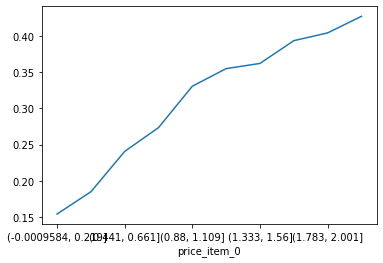

In [12]:
train_pricing_decisions.groupby(pd.qcut(train_pricing_decisions.price_item_0, 10))['item_bought'].agg(lambda x: np.mean([y==1 for y in x])).plot(kind='line')

In [13]:
item0_embedding

[0.12277592821655194,
 0.8848570813366212,
 -0.7556286732829098,
 0.9490172960627021,
 0.6702740700696965,
 -1.209413756554651,
 -0.2610547783766926,
 0.4517198188232259,
 -0.8265020776064129,
 0.2700059980528833]

In [14]:
item1_embedding

[0.659227815368504,
 -0.14133051653919068,
 0.08777977176734512,
 -1.0989246196354665,
 1.2703206502381699,
 2.4131725160613238,
 -0.7559907972194396,
 -0.9461158749689281,
 0.3349207822918375,
 -0.08573474488666911]

In [15]:
test_covariate

,Covariate 1,Covariate 2,Covariate 3
14001,0.649354,1.192877,1.278761
14002,0.804002,2.084810,1.505329
14003,0.421088,-0.071346,0.723959
14004,-0.650596,-0.239373,-0.125284
14005,0.419475,1.406506,0.374329
...,...,...,...
16908,0.284535,1.090016,0.060397
16909,-0.106769,0.260398,0.100340
16910,-0.833313,-0.682731,-0.559618
16911,0.554983,1.831613,1.247704


In [16]:
test_noisy_embedding

,0,1,2,3,4,5,6,7,8,9
14002,1.492988,0.047140,0.048591,0.026001,-1.629761,-0.016721,0.090931,0.169766,-0.899599,-0.018805
14003,0.093276,-0.163184,-0.039906,-0.224888,-2.477718,-0.056674,-0.115434,-0.091765,-0.220834,0.055823
14004,-0.440940,0.096289,0.174533,-0.108059,-1.621377,0.107749,-0.086002,-0.025520,-0.452487,-0.018741
14005,0.392678,-0.077457,-0.128898,0.014162,-0.689378,0.017189,-0.022301,-0.104232,0.006523,0.150065
14008,-0.238350,0.089915,0.074239,0.167718,-1.424571,0.146261,-0.017444,-0.210746,-0.030849,0.055849
...,...,...,...,...,...,...,...,...,...,...
16906,-0.908402,0.024301,0.149014,0.072127,-1.230583,0.048539,-0.019572,-0.157452,-0.058970,-0.036102
16907,-0.708751,0.042254,-0.159667,-0.156841,-1.606279,0.045914,-0.045956,-0.218642,0.447454,-0.220819
16910,-1.028795,-0.043339,-0.038314,-0.035766,-1.264450,-0.064646,0.067899,-0.288668,0.015174,-0.133577
16911,1.027718,0.012969,0.094810,0.085677,-1.240079,0.097358,0.015381,-0.165348,-0.613572,-0.020077


# New Section

In [17]:
indx = list(train_noisy_embedding.index)
indx_test = list(test_noisy_embedding.index)

In [18]:
boolean = train_covariate.index.isin(indx)
train = train_covariate[boolean]

# boolean_test = test_covariate.index.isin(tes)

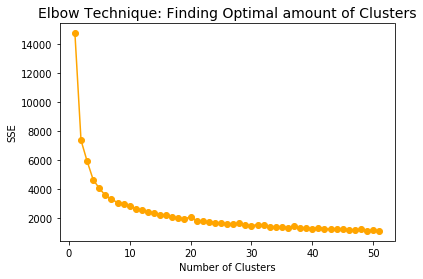

,K,Inertia
0,1.0,14730.907655
1,2.0,7367.811182
2,3.0,5929.159708
3,4.0,4650.673940
4,5.0,4060.071009
5,6.0,3567.708549
6,7.0,3307.647558
7,8.0,3077.380019
8,9.0,2967.872828
9,10.0,2818.931005


In [19]:
import sklearn.cluster
import sklearn.manifold
import matplotlib
import warnings
warnings.filterwarnings("ignore")

K_df = train.copy()
sse = {} #Create an empty dictionary
KVect = pd.DataFrame(columns=['K','Inertia']) #Create a new DataFrame
for k in range(1, 52): #clusters between 1 and 52 to see optimal cluster amount in elbow technique
    kmeansNew = sklearn.cluster.KMeans(n_clusters=k,n_init=3, init='k-means++',max_iter=20).fit(K_df) #Run the Kmeans function
    K_df["clusters"] = kmeansNew.labels_ #Grab the cluster label and store in the dataframe
    sse[k] = kmeansNew.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    KVect = KVect.append({'K':k,'Inertia':sse[k]},ignore_index=True) #Append each amount of cluster K with the Inertia

#Plotting Results for Visual Purposes
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(list(sse.keys()), list(sse.values()),marker='o',color='orange')
matplotlib.pyplot.title('Elbow Technique: Finding Optimal amount of Clusters',fontsize=14) #Put a big title
matplotlib.pyplot.xlabel("Number of Clusters") #Set the xlabel
matplotlib.pyplot.ylabel("SSE") #Set y label
matplotlib.pyplot.show() #Show plot
KVect.head(25)

In [20]:
train

,Covariate 1,Covariate 2,Covariate 3
2,0.863392,0.281688,0.224007
3,-1.015676,-0.952738,-1.094953
10,-0.372010,-0.319972,0.253917
11,-0.339109,0.089601,0.546554
12,-0.364249,-0.469027,-0.177252
...,...,...,...
13991,-0.985546,1.015400,0.129233
13993,0.255625,0.321469,0.426561
13995,-0.361261,-0.592478,-0.871861
13997,1.085208,1.391523,1.206599


In [21]:
from sklearn.cluster import KMeans
df = train.copy()
kmeans = KMeans(n_clusters=5) #fit the existing df with 5 clusters
kmeans.fit(df) 
labels = kmeans.predict(df) #create the labels
centroids = kmeans.cluster_centers_
# color data points based on cluster labels
colmap = {0:'r', 1:'orange', 2: 'b',3:'c',4:'g',5:'k',6:'y'} #Create a color map dictionary
df['Cluster'] = list(labels) 
df['color'] = df.Cluster.map(colmap)

In [22]:
df

,Covariate 1,Covariate 2,Covariate 3,Cluster,color
2,0.863392,0.281688,0.224007,4,g
3,-1.015676,-0.952738,-1.094953,1,orange
10,-0.372010,-0.319972,0.253917,2,b
11,-0.339109,0.089601,0.546554,0,r
12,-0.364249,-0.469027,-0.177252,2,b
...,...,...,...,...,...
13991,-0.985546,1.015400,0.129233,0,r
13993,0.255625,0.321469,0.426561,4,g
13995,-0.361261,-0.592478,-0.871861,2,b
13997,1.085208,1.391523,1.206599,3,c


Text(0, 0.5, 'Covariate 2')

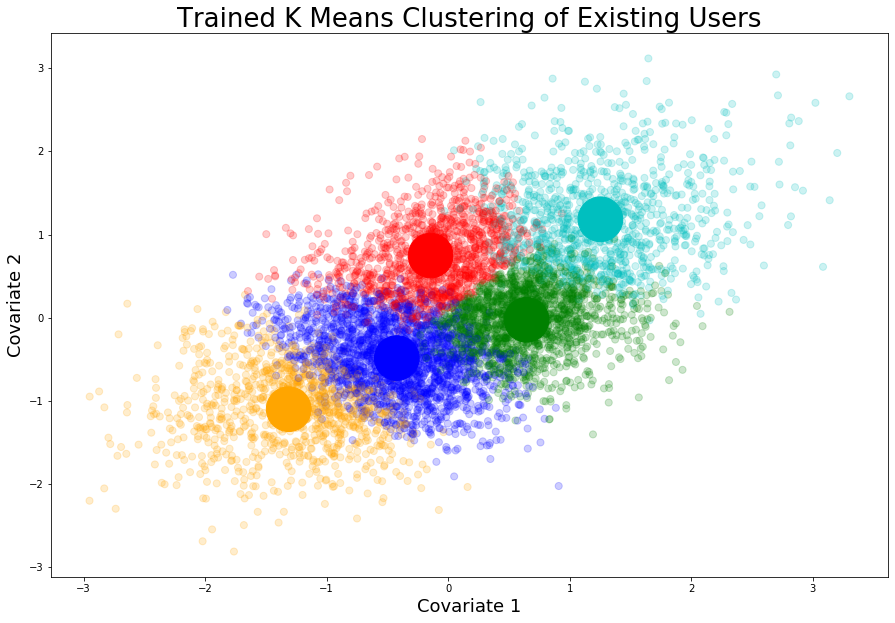

In [23]:
import matplotlib
p = df.plot.scatter(x='Covariate 1', y='Covariate 2', s=50, color=df['color'],figsize=(15,10),sharex=False,alpha=0.2) #Plot the figure

clusterDF = pd.DataFrame(columns=['Covariate 1', 'Covariate 2'])

for cluster in set(df.Cluster): #Find the clusters centroids based of the average of each cluster 0-4
    clusterDF = clusterDF.append(df[df.Cluster == cluster].mean(),ignore_index=True)
clusterDF.Cluster = clusterDF.Cluster.map(int) #Convert the clusters to int
clusterDF['color'] = clusterDF.Cluster.map(colmap) #Add the colors
matplotlib.pyplot.scatter(x=clusterDF['Covariate 1'],y=clusterDF['Covariate 2'],s=2000,color=clusterDF['color'],alpha=1) #Plot the centroids
p.set_title('Trained K Means Clustering of Existing Users',fontsize=26) #Put a big title
p.set_xlabel("Covariate 1", fontsize=18) #Put a x label
p.set_ylabel("Covariate 2", fontsize=18) #Put a y label

Text(0, 0.5, 'Covariate 3')

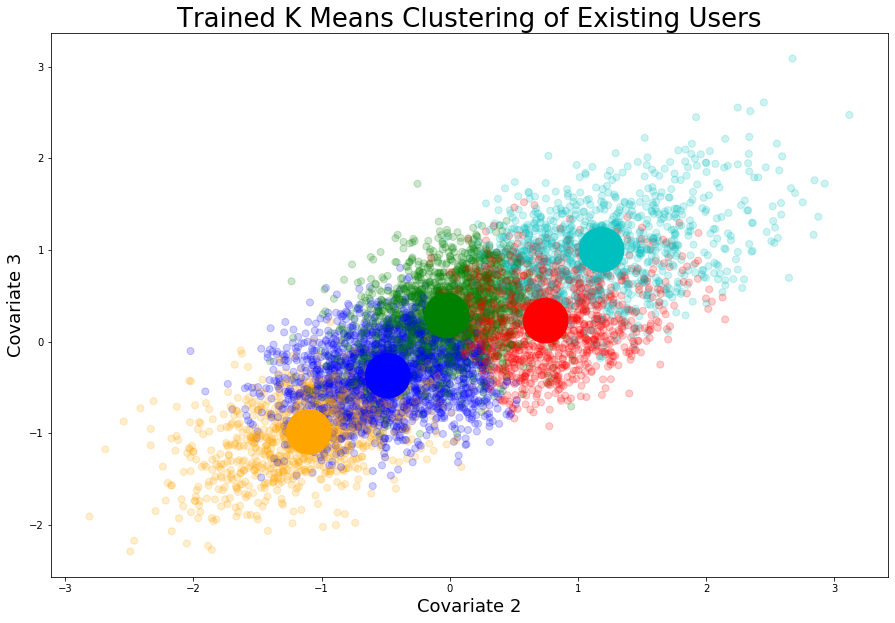

In [24]:
import matplotlib
p = df.plot.scatter(x='Covariate 2', y='Covariate 3', s=50, color=df['color'],figsize=(15,10),sharex=False, alpha=0.2) #Plot the figure

clusterDF = pd.DataFrame(columns=['Covariate 2', 'Covariate 3'])

for cluster in set(df.Cluster): #Find the clusters centroids based of the average of each cluster 0-4
    clusterDF = clusterDF.append(df[df.Cluster == cluster].mean(),ignore_index=True)
clusterDF.Cluster = clusterDF.Cluster.map(int) #Convert the clusters to int
clusterDF['color'] = clusterDF.Cluster.map(colmap) #Add the colors
matplotlib.pyplot.scatter(x=clusterDF['Covariate 2'],y=clusterDF['Covariate 3'],s=2000,color=clusterDF['color'],alpha=1.0) #Plot the centroids
p.set_title('Trained K Means Clustering of Existing Users',fontsize=26) #Put a big title
p.set_xlabel("Covariate 2", fontsize=18) #Put a x label
p.set_ylabel("Covariate 3", fontsize=18) #Put a y label

In [25]:
boolean = ~train_covariate.index.isin(indx)
new_users = train_covariate[boolean]

In [26]:
new_users

,Covariate 1,Covariate 2,Covariate 3
1,0.729640,1.095115,1.188253
4,-0.956540,-0.564787,-0.814503
5,0.159077,-0.172509,-0.028074
6,1.761598,0.338015,0.618013
7,-0.064137,-0.616533,-0.276820
...,...,...,...
13992,0.395554,-0.222853,0.341593
13994,-1.104986,-0.299675,-0.019393
13996,1.081516,0.042608,0.639034
13998,-0.104681,1.192965,-0.310867


In [27]:
indx_test = list(test_noisy_embedding.index)
boolean_test = ~test_covariate.index.isin(indx_test)
new_users_test = test_covariate[boolean_test]
test = test_covariate[~boolean_test]
test

,Covariate 1,Covariate 2,Covariate 3
14002,0.804002,2.084810,1.505329
14003,0.421088,-0.071346,0.723959
14004,-0.650596,-0.239373,-0.125284
14005,0.419475,1.406506,0.374329
14008,-0.173928,0.046112,0.191354
...,...,...,...
16906,-0.960618,-0.688258,-0.546664
16907,0.094740,-0.457755,-0.238737
16910,-0.833313,-0.682731,-0.559618
16911,0.554983,1.831613,1.247704


# New Users from training set

Text(0, 0.5, 'Covariate 2')

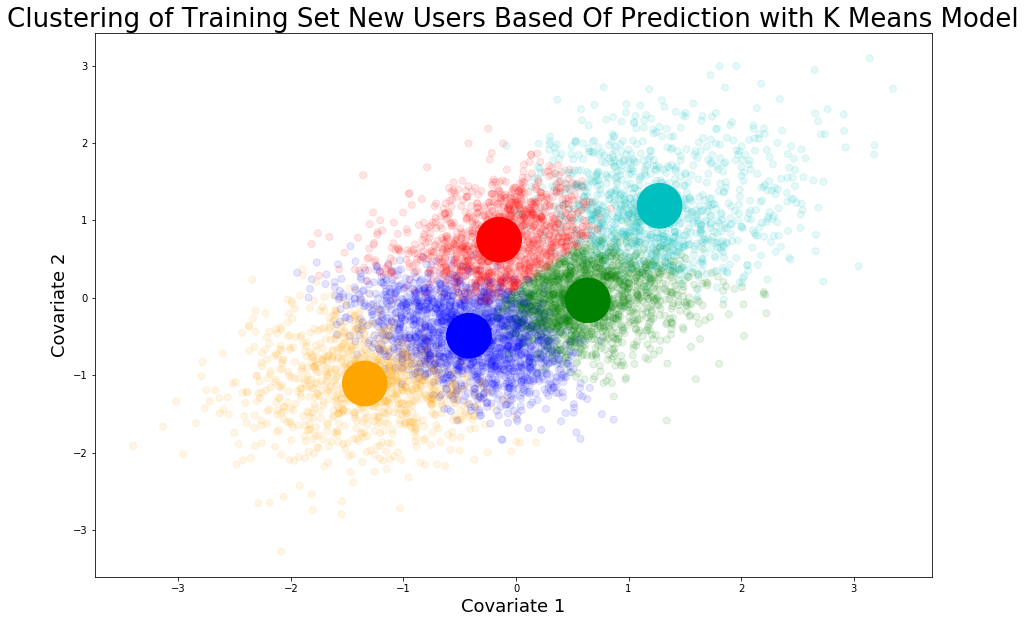

In [28]:
df2 = new_users.copy()
labels = kmeans.predict(df2) #create the labels for New Users
centroids = kmeans.cluster_centers_ #retrieve centroids
# color data points based on cluster labels
colmap = {0:'r', 1:'orange', 2: 'b',3:'c',4:'g',5:'k',6:'y'} #Create a color map dictionary
df2['Cluster'] = list(labels) #assign labels to df2 users
df2['color'] = df2.Cluster.map(colmap) #assign colors for plotting
import matplotlib
p = df2.plot.scatter(x='Covariate 1', y='Covariate 2', s=50, color=df2['color'],figsize=(15,10),sharex=False, alpha = 0.1) #Plot the figure
clusterDF = pd.DataFrame(columns=['Covariate 1', 'Covariate 2'])

for cluster in set(df2.Cluster): #Find the clusters centroids based of the average of each cluster 0-4
    clusterDF = clusterDF.append(df2[df2.Cluster == cluster].mean(),ignore_index=True)
clusterDF.Cluster = clusterDF.Cluster.map(int) #Convert the clusters to int
clusterDF['color'] = clusterDF.Cluster.map(colmap) #Add the colors
clusterDF
matplotlib.pyplot.scatter(x=clusterDF['Covariate 1'],y=clusterDF['Covariate 2'],s=2000,color=clusterDF['color'],alpha=1.0) #Plot the centroids
p.set_title('Clustering of Training Set New Users Based Of Prediction with K Means Model',fontsize=26) #Put a big title
p.set_xlabel("Covariate 1", fontsize=18) #Put a x label
p.set_ylabel("Covariate 2", fontsize=18) #Put a y label

# Assign clusters to users in test set

Text(0, 0.5, 'Covariate 2')

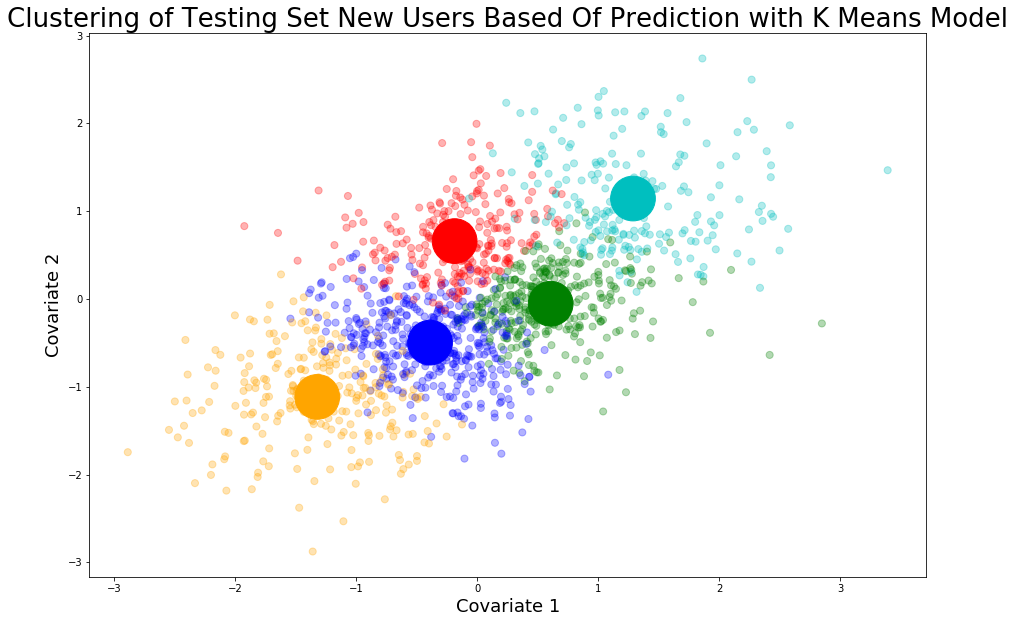

In [29]:
df2_test = new_users_test.copy()
labels = kmeans.predict(df2_test) #create the labels for New Users
centroids = kmeans.cluster_centers_ #retrieve centroids
# color data points based on cluster labels
colmap = {0:'r', 1:'orange', 2: 'b',3:'c',4:'g',5:'k',6:'y'} #Create a color map dictionary
df2_test['Cluster'] = list(labels) #assign labels to df2_test users
df2_test['color'] = df2_test.Cluster.map(colmap) #assign colors for plotting
import matplotlib
p = df2_test.plot.scatter(x='Covariate 1', y='Covariate 2', s=50, color=df2_test['color'],figsize=(15,10),sharex=False, alpha = 0.3) #Plot the figure
clusterDF = pd.DataFrame(columns=['Covariate 1', 'Covariate 2'])

for cluster in set(df2_test.Cluster): #Find the clusters centroids based of the average of each cluster 0-4
    clusterDF = clusterDF.append(df2_test[df2_test.Cluster == cluster].mean(),ignore_index=True)
clusterDF.Cluster = clusterDF.Cluster.map(int) #Convert the clusters to int
clusterDF['color'] = clusterDF.Cluster.map(colmap) #Add the colors
clusterDF
matplotlib.pyplot.scatter(x=clusterDF['Covariate 1'],y=clusterDF['Covariate 2'],s=2000,color=clusterDF['color'],alpha=1.0) #Plot the centroids
p.set_title('Clustering of Testing Set New Users Based Of Prediction with K Means Model',fontsize=26) #Put a big title
p.set_xlabel("Covariate 1", fontsize=18) #Put a x label
p.set_ylabel("Covariate 2", fontsize=18) #Put a y label

In [30]:
#Helper function to calculate the prediction vector for a new user
def get_predicted_vect_kmeans(check,existing_df, existing_user_vectors):
    #if check is set to true
    dnew = existing_df[existing_df.Cluster == check]

    #get the User IDs for this df but subtract 1 to make sure its python indexing
    #filtered is isin
    indices = dnew.index
    boolean = existing_user_vectors.index.isin(indices)
    frame = existing_user_vectors[boolean]

    # #print(filter_indices)
    # #filter the existing user vector by these indices
    #filteredArray = np.take(existing_user_vectors, filter_indices, axis=0)
    #average the filtered array over each column
    pred_vict = np.average(frame, axis=0)
    return pred_vict

In [31]:
def get_user_vector_for_new_user_kmeans(new_user_df, existing_df, existing_user_vectors):
    #get the cluster vect by calling the helper functions
    Zero_vect = get_predicted_vect_kmeans(0,existing_df, existing_user_vectors)
    One_vect = get_predicted_vect_kmeans(1,existing_df, existing_user_vectors)
    Two_vect = get_predicted_vect_kmeans(2,existing_df, existing_user_vectors)
    Three_vect = get_predicted_vect_kmeans(3,existing_df, existing_user_vectors)
    Four_vect = get_predicted_vect_kmeans(4,existing_df, existing_user_vectors)
   
    #make a copy of the new_user frame 
    new_user1 = new_user_df.copy()
    #Adding the low or high vect depending on Wealth attribute High or low
    new_user1['Predicted K Means Vector'] = new_user1['Cluster'].map({0:Zero_vect,1:One_vect,2:Two_vect,3:Three_vect,4:Four_vect})  
    #Return the Data Frame
    return new_user1

# Getting the Predicted K Means Vector for New Users Training

In [32]:
# existing_users = train.copy()
# existing_users['Cluster'] = df['Cluster'] #adding cluster assignments to existing demographics
# usernew = new_users.copy()
# usernew['Cluster'] = df2['Cluster'] #adding cluster assignments to the new user dempgrahics
new_user3 = get_user_vector_for_new_user_kmeans(df2,df,train_noisy_embedding)
new_user3
# print('User 1 Predicted Vector \n','Assignment Cluster ', new_user3)

,Covariate 1,Covariate 2,Covariate 3,Cluster,color,Predicted K Means Vector
1,0.729640,1.095115,1.188253,3,c,"[0.707650605555874, -0.021806074621994354, -0...."
4,-0.956540,-0.564787,-0.814503,1,orange,"[-1.2524259105153295, -0.019129788675576444, -..."
5,0.159077,-0.172509,-0.028074,4,g,"[-0.10330661916397076, -0.021069752517277024, ..."
6,1.761598,0.338015,0.618013,3,c,"[0.707650605555874, -0.021806074621994354, -0...."
7,-0.064137,-0.616533,-0.276820,2,b,"[-0.6771859449160907, -0.022436480367903397, -..."
...,...,...,...,...,...,...
13992,0.395554,-0.222853,0.341593,4,g,"[-0.10330661916397076, -0.021069752517277024, ..."
13994,-1.104986,-0.299675,-0.019393,2,b,"[-0.6771859449160907, -0.022436480367903397, -..."
13996,1.081516,0.042608,0.639034,4,g,"[-0.10330661916397076, -0.021069752517277024, ..."
13998,-0.104681,1.192965,-0.310867,0,r,"[0.04239314819098868, -0.02968864336811448, -0..."


# Getting the Predicted K Means Vector for New Users Test Set

In [33]:
new_user_test = get_user_vector_for_new_user_kmeans(df2_test,df,train_noisy_embedding)
new_user_test

,Covariate 1,Covariate 2,Covariate 3,Cluster,color,Predicted K Means Vector
14001,0.649354,1.192877,1.278761,3,c,"[0.707650605555874, -0.021806074621994354, -0...."
14006,0.504054,1.538468,1.284483,3,c,"[0.707650605555874, -0.021806074621994354, -0...."
14007,1.285770,-0.222947,-0.031774,4,g,"[-0.10330661916397076, -0.021069752517277024, ..."
14009,0.052055,-0.850115,0.319761,2,b,"[-0.6771859449160907, -0.022436480367903397, -..."
14014,1.097692,1.107363,0.149376,3,c,"[0.707650605555874, -0.021806074621994354, -0...."
...,...,...,...,...,...,...
16900,-0.203025,-1.299489,-1.105099,2,b,"[-0.6771859449160907, -0.022436480367903397, -..."
16903,0.210564,-0.201996,-0.311420,2,b,"[-0.6771859449160907, -0.022436480367903397, -..."
16905,-1.705096,-0.636525,-0.488217,1,orange,"[-1.2524259105153295, -0.019129788675576444, -..."
16908,0.284535,1.090016,0.060397,0,r,"[0.04239314819098868, -0.02968864336811448, -0..."


In [34]:
# Getting the predictions for the new users
def get_predictions(user_vectors, book_vectors):
    return np.dot(user_vectors,book_vectors.T) 


## getting the item predictions for the training set new users

In [35]:
cold_start_users = np.stack(new_user3['Predicted K Means Vector'].values)

item0_pred_new = get_predictions(cold_start_users, np.array(item0_embedding))
item1_pred_new = get_predictions(cold_start_users, np.array(item1_embedding))

item0_pred_exi = get_predictions(train_noisy_embedding, np.array(item0_embedding))
item1_pred_exi = get_predictions(train_noisy_embedding, np.array(item1_embedding))


In [36]:

new_mapper_0 = dict(list(zip(list(new_user3.index), item0_pred_new)))
new_mapper_1 = dict(list(zip(list(new_user3.index), item1_pred_new)))
exi_mapper_0 = dict(list(zip(list(train_noisy_embedding.index), item0_pred_exi)))
exi_mapper_1 = dict(list(zip(list(train_noisy_embedding.index), item1_pred_exi)))

new_mapper_0.update(exi_mapper_0)
new_mapper_1.update(exi_mapper_1)


train_pricing_decisions['item0_pred'] = train_pricing_decisions.user_index.map(new_mapper_0)
train_pricing_decisions['item1_pred'] = train_pricing_decisions.user_index.map(new_mapper_1)


train_pricing_decisions

,user_index,item_bought,price_item_0,price_item_1,item0_pred,item1_pred
0,1,0,0.719986,2.356496,-1.317815,-1.179955
1,2,1,0.296607,1.443239,-2.171722,-0.834394
2,3,0,1.652173,3.554441,-0.618320,-3.603190
3,4,1,1.358742,0.326100,-0.937157,-2.570672
4,5,0,1.082251,3.010197,-1.699132,-2.091807
...,...,...,...,...,...,...
13995,13996,-1,1.796187,1.706831,-1.699132,-2.091807
13996,13997,-1,1.812449,3.133188,-1.429388,-0.592335
13997,13998,1,1.261933,1.732192,-0.574144,-1.193035
13998,13999,0,0.296810,1.001047,-0.574144,-1.193035


In [37]:
train_pricing_decisions.index += 1

In [38]:
training_set = pd.concat([train_pricing_decisions, train_covariate], axis =1)

In [39]:
training_set

,user_index,item_bought,price_item_0,price_item_1,item0_pred,item1_pred,Covariate 1,Covariate 2,Covariate 3
1,1,0,0.719986,2.356496,-1.317815,-1.179955,0.729640,1.095115,1.188253
2,2,1,0.296607,1.443239,-2.171722,-0.834394,0.863392,0.281688,0.224007
3,3,0,1.652173,3.554441,-0.618320,-3.603190,-1.015676,-0.952738,-1.094953
4,4,1,1.358742,0.326100,-0.937157,-2.570672,-0.956540,-0.564787,-0.814503
5,5,0,1.082251,3.010197,-1.699132,-2.091807,0.159077,-0.172509,-0.028074
...,...,...,...,...,...,...,...,...,...
13996,13996,-1,1.796187,1.706831,-1.699132,-2.091807,1.081516,0.042608,0.639034
13997,13997,-1,1.812449,3.133188,-1.429388,-0.592335,1.085208,1.391523,1.206599
13998,13998,1,1.261933,1.732192,-0.574144,-1.193035,-0.104681,1.192965,-0.310867
13999,13999,0,0.296810,1.001047,-0.574144,-1.193035,-0.232824,0.082345,0.011095


## getting the item predictions for the testing set new users

In [40]:
cold_start_users_test = np.stack(new_user_test['Predicted K Means Vector'].values)

item0_pred_new = get_predictions(cold_start_users_test, np.array(item0_embedding))
item1_pred_new = get_predictions(cold_start_users_test, np.array(item1_embedding))

item0_pred_exi = get_predictions(test_noisy_embedding, np.array(item0_embedding))
item1_pred_exi = get_predictions(test_noisy_embedding, np.array(item1_embedding))


In [41]:
test_noisy_embedding.index

Int64Index([14002, 14003, 14004, 14005, 14008, 14010, 14011, 14012, 14013,
            14015,
            ...
            16896, 16899, 16901, 16902, 16904, 16906, 16907, 16910, 16911,
            16912],
           dtype='int64', length=1456)

In [42]:
new_user_test.index

Int64Index([14001, 14006, 14007, 14009, 14014, 14016, 14018, 14019, 14020,
            14023,
            ...
            16887, 16889, 16895, 16897, 16898, 16900, 16903, 16905, 16908,
            16909],
           dtype='int64', length=1456)

In [43]:

new_mapper_0 = dict(list(zip(list(new_user_test.index), item0_pred_new)))
new_mapper_1 = dict(list(zip(list(new_user_test.index), item1_pred_new)))
exi_mapper_0 = dict(list(zip(list(test_noisy_embedding.index), item0_pred_exi)))
exi_mapper_1 = dict(list(zip(list(test_noisy_embedding.index), item1_pred_exi)))

new_mapper_0.update(exi_mapper_0)
new_mapper_1.update(exi_mapper_1)

test_pricing_decisions = pd.DataFrame(columns=['user_index'])
test_pricing_decisions['user_index'] = list(range(14001,16913))

test_pricing_decisions['item0_pred'] = test_pricing_decisions.user_index.map(new_mapper_0)
test_pricing_decisions['item1_pred'] = test_pricing_decisions.user_index.map(new_mapper_1)


test_pricing_decisions

,user_index,item0_pred,item1_pred
0,14001,-1.317815,-1.179955
1,14002,-0.067799,-1.686465
2,14003,-1.722144,-2.860737
3,14004,-1.040604,-2.030649
4,14005,-0.398483,-0.486523
...,...,...,...
2907,16908,-0.574144,-1.193035
2908,16909,-0.574144,-1.193035
2909,16910,-1.135727,-2.160087
2910,16911,-0.378625,-0.809486


In [44]:
test_pricing_decisions.index += 14001

In [122]:
test_set = pd.concat([test_pricing_decisions, test_covariate], axis =1)

In [123]:
test_set

,user_index,item0_pred,item1_pred,Covariate 1,Covariate 2,Covariate 3
14001,14001,-1.317815,-1.179955,0.649354,1.192877,1.278761
14002,14002,-0.067799,-1.686465,0.804002,2.084810,1.505329
14003,14003,-1.722144,-2.860737,0.421088,-0.071346,0.723959
14004,14004,-1.040604,-2.030649,-0.650596,-0.239373,-0.125284
14005,14005,-0.398483,-0.486523,0.419475,1.406506,0.374329
...,...,...,...,...,...,...
16908,16908,-0.574144,-1.193035,0.284535,1.090016,0.060397
16909,16909,-0.574144,-1.193035,-0.106769,0.260398,0.100340
16910,16910,-1.135727,-2.160087,-0.833313,-0.682731,-0.559618
16911,16911,-0.378625,-0.809486,0.554983,1.831613,1.247704


In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(training_set.iloc[:, 2:], training_set.item_bought, test_size=0.01, random_state=0)

In [107]:
X = training_set.iloc[:, 2:]
y = training_set.item_bought

In [108]:
from sklearn.linear_model import LogisticRegression
def fit_logistic_regression_demand_just_on_price(X,y):
    clf = LogisticRegression(random_state=0, multi_class = 'multinomial').fit(X, y)
    return clf

In [109]:
classifier = fit_logistic_regression_demand_just_on_price(X_train, y_train)
classifier_full = fit_logistic_regression_demand_just_on_price(X, y)

In [110]:
def get_prediction_logistic(fitted_model, row):
    return fitted_model.predict_proba(row)
    #return fitted_model.predict(row)

In [111]:
pred = get_prediction_logistic(classifier, X_test)
#pred_full = get_prediction_logistic(classifier_full, test)

In [112]:
min_item0_price = min(training_set.price_item_0)
max_item0_price = max(training_set.price_item_0)
min_item1_price = min(training_set.price_item_1)
max_item1_price = max(training_set.price_item_1)



In [168]:
def get_revenue_maximizing_price_and_revenue(price_options, demand_predictions):
    #create a new data frame with Price, Demand and Revenue
    df = pd.DataFrame(columns=['Price_item_0', 'Price_item_1','Demand Estimate_0','Demand Estimate_1','Revenue'])
    #Price column equals the passed in prices
    df['Price_item_0'] = price_options[0]
    df['Price_item_1'] = price_options[1]
    #Demand column equals the passed in demand
    #print(demand_predictions)
    df['Demand Estimate_0'] = demand_predictions[0]
    df['Demand Estimate_1'] = demand_predictions[1]
    #Revenue is a product of price x demand
    df['Revenue'] =  df['Price_item_0']*df['Demand Estimate_0'] + df['Price_item_1']*df['Demand Estimate_1']
    #get the index where the revenue is optimal
    index = df['Revenue'].idxmax()
    #return the index, optimal price, and computed revenue
    return index, df['Price_item_0'].iloc[index], df['Price_item_1'].iloc[index],df['Revenue'].iloc[index]

In [169]:
item0_prices = np.arange(min_item0_price, max_item0_price, .05)

In [170]:
item1_prices = np.arange(min_item1_price, max_item1_price, .05)

In [171]:
list_prices = []
for x in item0_prices:
    for y in item1_prices:
        list_prices.append([x,y])

In [172]:
np.array(list_prices).T.shape

(2, 3600)

In [118]:
X_test.iloc[0]

price_item_0    0.476158
price_item_1    3.652999
item0_pred     -1.317815
item1_pred     -1.179955
Covariate 1     0.910115
Covariate 2     1.048297
Covariate 3     0.536633
Name: 6039, dtype: float64

In [65]:
#list_prices

In [66]:
# for j in range(0, len(X_test.index)):
#   print(j)

In [ ]:
# list_price_0 = []
# list_price_1 = []
# revenue_list = []
# index_list = []
# for j in range(0, len(X_test.index)):
#   demand_list = []
#   for i, price in enumerate(list_prices):
    
#     predictor = [price + list(X_test.iloc[j,2:,])]
#     demands = get_prediction_logistic(classifier, predictor)
#     demands = list(demands[0][1:])
#     demand_list.append(demands)
#   index, p0, p1, revenue = get_revenue_maximizing_price_and_revenue(np.array(list_prices).T, np.array(demand_list).T)
#   list_price_0.append(p0)
#   list_price_1.append(p1)
#   revenue_list.append(revenue)
#   index_list.append(index)

In [ ]:
# sum(revenue_list)

In [119]:
X

,price_item_0,price_item_1,item0_pred,item1_pred,Covariate 1,Covariate 2,Covariate 3
1,0.719986,2.356496,-1.317815,-1.179955,0.729640,1.095115,1.188253
2,0.296607,1.443239,-2.171722,-0.834394,0.863392,0.281688,0.224007
3,1.652173,3.554441,-0.618320,-3.603190,-1.015676,-0.952738,-1.094953
4,1.358742,0.326100,-0.937157,-2.570672,-0.956540,-0.564787,-0.814503
5,1.082251,3.010197,-1.699132,-2.091807,0.159077,-0.172509,-0.028074
...,...,...,...,...,...,...,...
13996,1.796187,1.706831,-1.699132,-2.091807,1.081516,0.042608,0.639034
13997,1.812449,3.133188,-1.429388,-0.592335,1.085208,1.391523,1.206599
13998,1.261933,1.732192,-0.574144,-1.193035,-0.104681,1.192965,-0.310867
13999,0.296810,1.001047,-0.574144,-1.193035,-0.232824,0.082345,0.011095


In [126]:
test_set_new = test_set.iloc[:, 1:]
test_set_new

,item0_pred,item1_pred,Covariate 1,Covariate 2,Covariate 3
14001,-1.317815,-1.179955,0.649354,1.192877,1.278761
14002,-0.067799,-1.686465,0.804002,2.084810,1.505329
14003,-1.722144,-2.860737,0.421088,-0.071346,0.723959
14004,-1.040604,-2.030649,-0.650596,-0.239373,-0.125284
14005,-0.398483,-0.486523,0.419475,1.406506,0.374329
...,...,...,...,...,...
16908,-0.574144,-1.193035,0.284535,1.090016,0.060397
16909,-0.574144,-1.193035,-0.106769,0.260398,0.100340
16910,-1.135727,-2.160087,-0.833313,-0.682731,-0.559618
16911,-0.378625,-0.809486,0.554983,1.831613,1.247704


In [173]:
list_price_0 = []
list_price_1 = []
revenue_list = []
index_list = []
import numpy as np
for j in range(0, len(test_set_new.index)):
    demand_list = []
    for i, price in enumerate(list_prices):
        predictor = [price + list(test_set_new.iloc[j, :])]
        demands = get_prediction_logistic(classifier_full, predictor)
        demand_val = demands[0][1:]
        demand_list.append(demand_val)
    index, p0, p1, revenue = get_revenue_maximizing_price_and_revenue(np.array(list_prices).T, np.array(demand_list).T)
    list_price_0.append(p0)
    list_price_1.append(p1)
    revenue_list.append(revenue)
    index_list.append(index)

In [174]:
sum(revenue_list)

4109.827608858887

In [105]:
demands

[0.08256861166171432, 0.9174215797163539]

In [175]:
final_results = pd.DataFrame({'user_index': list(test_set.index), 'price_item_0': list_price_0, 'price_item_1': list_price_1, 'expected_revenue': revenue_list})
final_results.to_csv(colab_path + 'Price_Results_0.05.csv', header = True)

NameError: name 'colab_path' is not defined

In [ ]:
test_set.iloc[0, :]

In [ ]:
# predictor = [list_prices[0] + list(X_test.iloc[0,2:,])]
# demands = get_prediction_logistic(classifier, predictor)
# demands = demands[0][1:]

In [ ]:
# demand_list = []
# for i, price in enumerate(list_prices):
#   predictor = [price + list(X_test.iloc[0,2:,])]
#   demands = get_prediction_logistic(classifier, predictor)
#   demands = list(demands[0][1:])
#   demand_list.append(demands)
# get_revenue_maximizing_price_and_revenue(np.array(list_prices).T, np.array(demand_list).T)